In [1]:
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/g46dvrcvwn/files/60aa59c1-cd77-4c8a-9573-50d2fd8b10e9/file_downloaded"

--2025-11-28 14:31:45--  https://data.mendeley.com/public-files/datasets/g46dvrcvwn/files/60aa59c1-cd77-4c8a-9573-50d2fd8b10e9/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/6fa5ad64-11e3-451a-84a9-d834be2517ec [following]
--2025-11-28 14:31:46--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/6fa5ad64-11e3-451a-84a9-d834be2517ec
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.71.201, 3.5.72.112, 52.92.1.66, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.71.201|:443... conn

In [2]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: Turmeric Plant Disease Augmented Dataset/
   creating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00001_aug_0.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00001_aug_1.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00001_aug_2.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00001_aug_3.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00002_aug_4.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00002_aug_5.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00002_aug_6.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00002_aug_7.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00003_aug_10.jpg  
  inflating: Turmeric Plant Disease Augmented Da

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
!pip install split-folders

In [5]:
import splitfolders
splitfolders.ratio("/content/Turmeric Plant Disease Augmented Dataset", output="dataset", seed=1337, ratio=(.8, .1,.1))

Copying files: 4548 files [00:16, 277.29 files/s]


**Data Preprocessing**

In [6]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3637 files belonging to 5 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dir = "/content/dataset/test"
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 453 files belonging to 5 classes.
Found 458 files belonging to 5 classes.


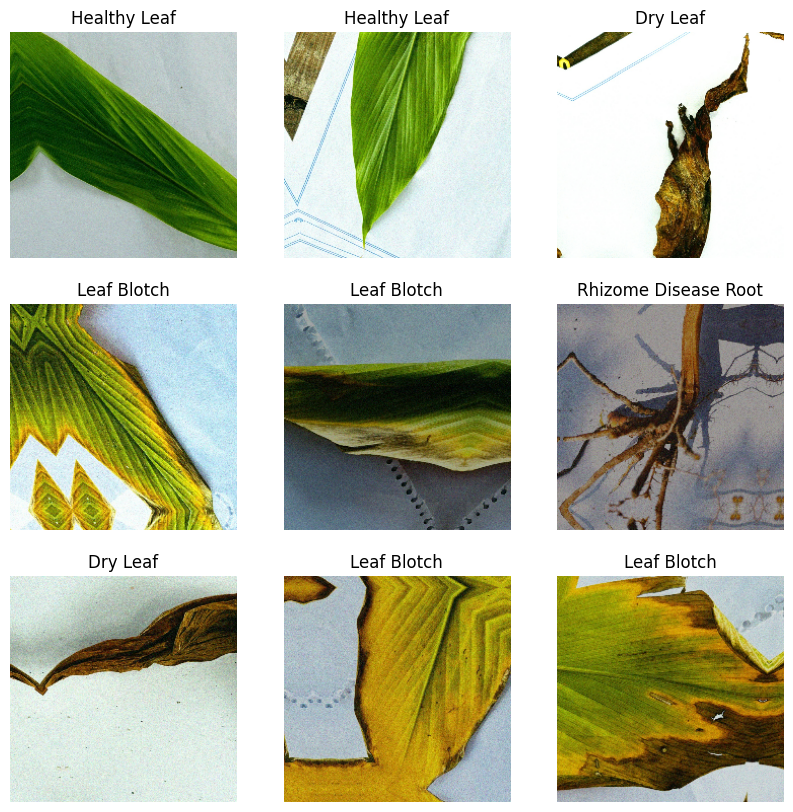

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
class_names

['Dry Leaf',
 'Healthy Leaf',
 'Leaf Blotch',
 'Rhizome Disease Root',
 'Rhizome Healthy Root']

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

**Create the base model from the pre-trained convnets**

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1792)


## **Feature extraction**
**Freeze the convolutional base**

In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [17]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [18]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         8,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,682,788 (67.45 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [20]:
len(model.trainable_variables)

2

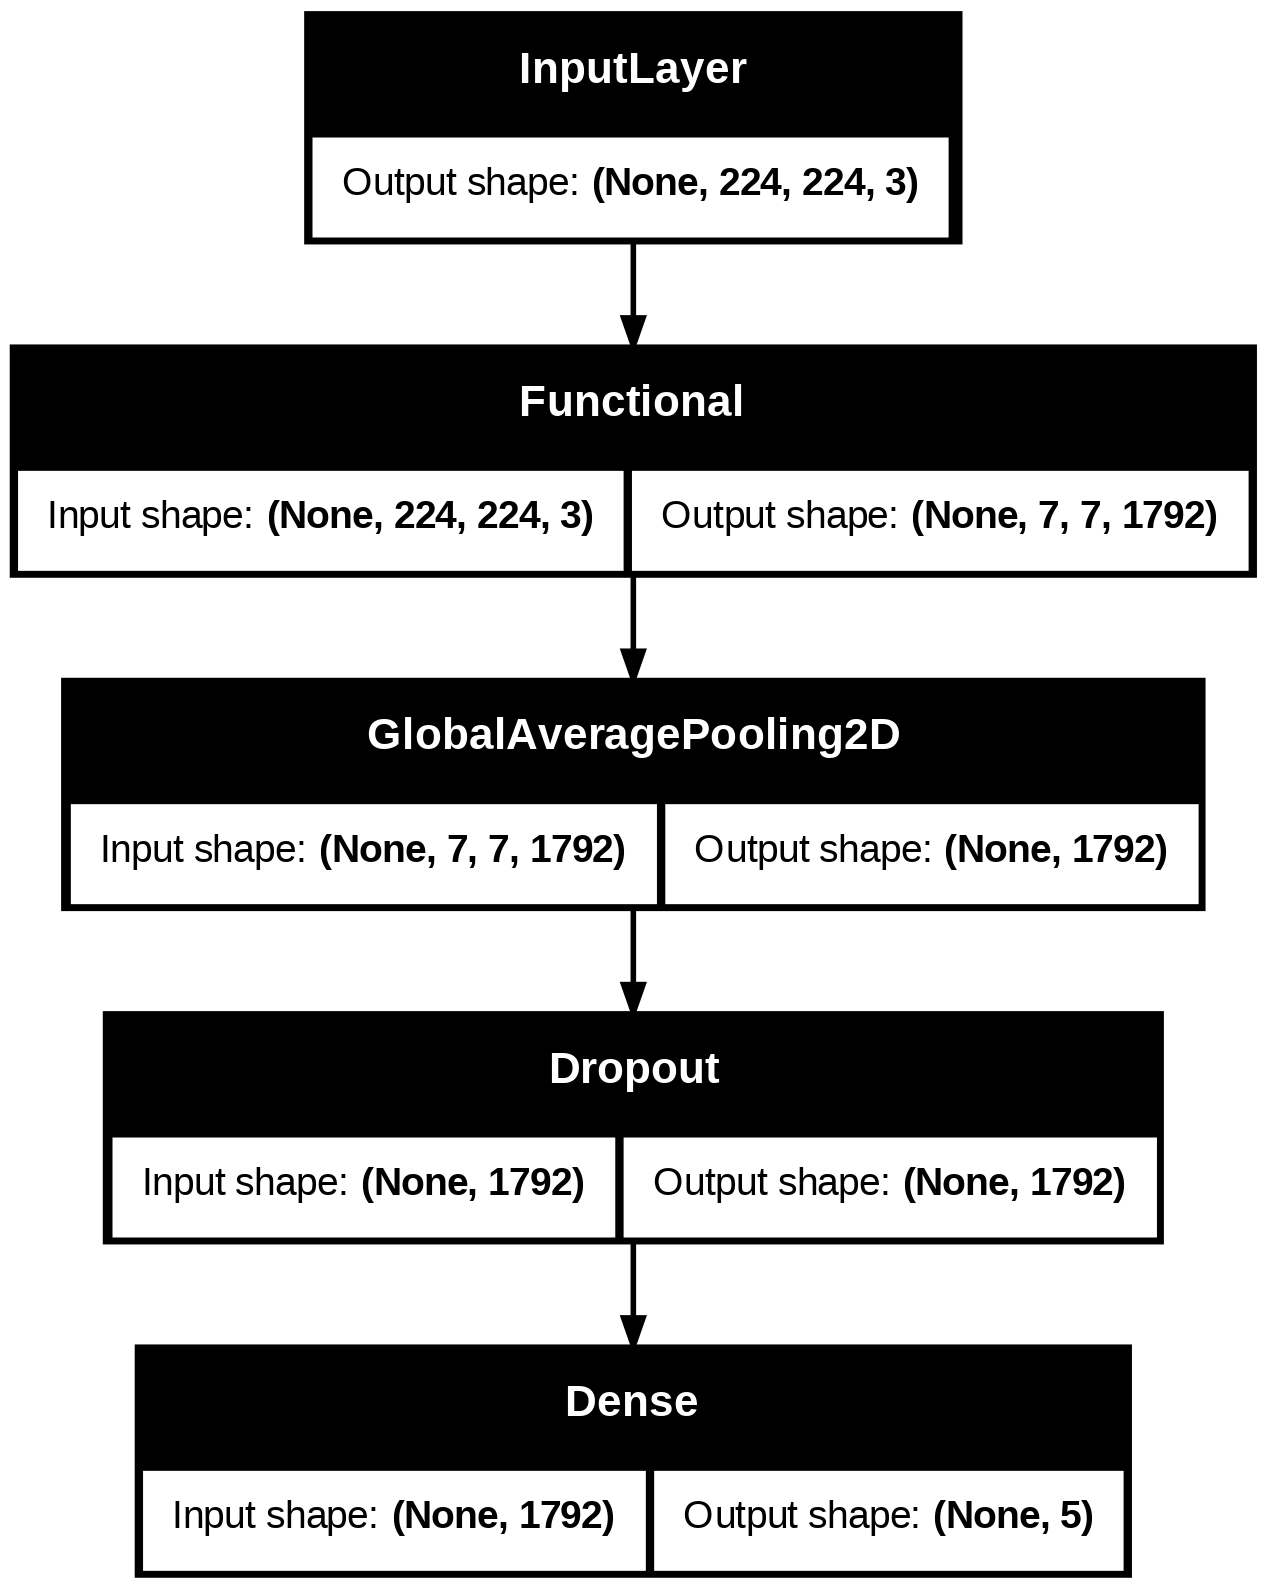

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

no coustome learning rate, all ready it is standard

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss="sparse_categorical_crossentropy",
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [23]:
initial_epochs = 6

loss0, accuracy0 = model.evaluate(validation_dataset)

15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1685 - loss: 1.7631


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.75
initial accuracy: 0.17


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 110s 587ms/step - accuracy: 0.7739 - loss: 0.6963 - val_accuracy: 0.9669 - val_loss: 0.1353
Epoch 2/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 36s 314ms/step - accuracy: 0.9683 - loss: 0.1364 - val_accuracy: 0.9779 - val_loss: 0.0840
Epoch 3/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step - accuracy: 0.9852 - loss: 0.0841 - val_accuracy: 0.9912 - val_loss: 0.0574
Epoch 4/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 35s 306ms/step - accuracy: 0.9862 - loss: 0.0643 - val_accuracy: 0.9934 - val_loss: 0.0483
Epoch 5/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 43s 326ms/step - accuracy: 0.9904 - loss: 0.0540 - val_accuracy: 0.9956 - val_loss: 0.0393
Epoch 6/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - accuracy: 0.9891 - loss: 0.0465 - val_accuracy: 0.9956 - val_loss: 0.0362


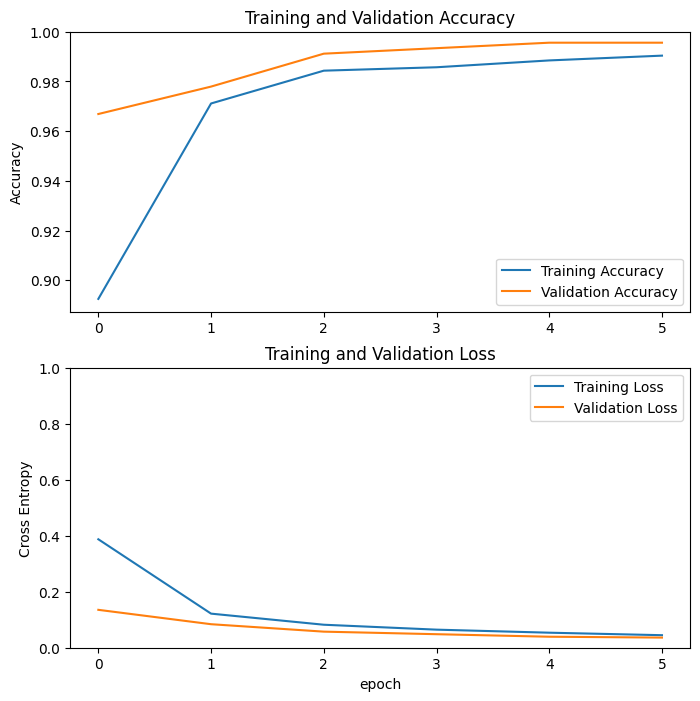

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **Fine tuning**

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         8,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,682,788 (67.45 MB)

 Trainable params: 17,470,821 (66.65 MB)

 Non-trainable params: 211,967 (828.00 KB)

In [31]:
len(model.trainable_variables)

333

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 7/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9296 - loss: 0.2190 - val_accuracy: 0.9404 - val_loss: 0.3385
Epoch 8/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 39s 337ms/step - accuracy: 0.9832 - loss: 0.0405 - val_accuracy: 0.9779 - val_loss: 0.0466
Epoch 9/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 359ms/step - accuracy: 0.9935 - loss: 0.0208 - val_accuracy: 0.9934 - val_loss: 0.0631
Epoch 10/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 39s 337ms/step - accuracy: 0.9975 - loss: 0.0077 - val_accuracy: 0.9978 - val_loss: 0.0119
Epoch 11/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 0.9739 - loss: 0.1438 - val_accuracy: 0.9051 - val_loss: 1.5854
Epoch 12/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 337ms/step - accuracy: 0.9883 - loss: 0.0498 - val_accuracy: 0.9934 - val_loss: 0.0210
Epoch 13/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 336ms/step - accuracy: 0.9897 - loss: 0.0288 - val_accuracy: 0.9934 - val_loss: 0.0110
Epoch 14/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 39s 341ms/step - accuracy: 0.9967 - loss

In [39]:
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


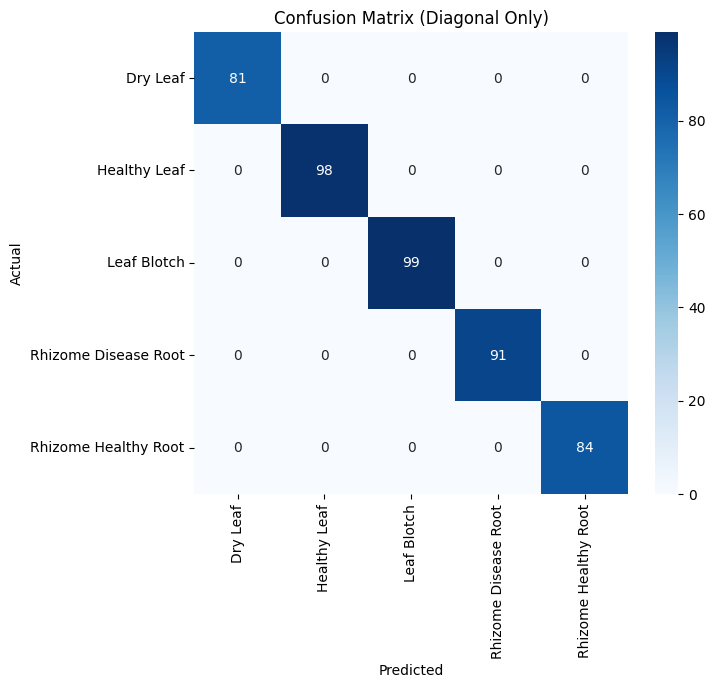

In [40]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix from your y_true, y_pred
cm = confusion_matrix(y_true, y_pred)

# diagonal-only matrix
cm_diagonal = np.zeros_like(cm)
np.fill_diagonal(cm_diagonal, np.diag(cm))

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_diagonal,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix (Diagonal Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

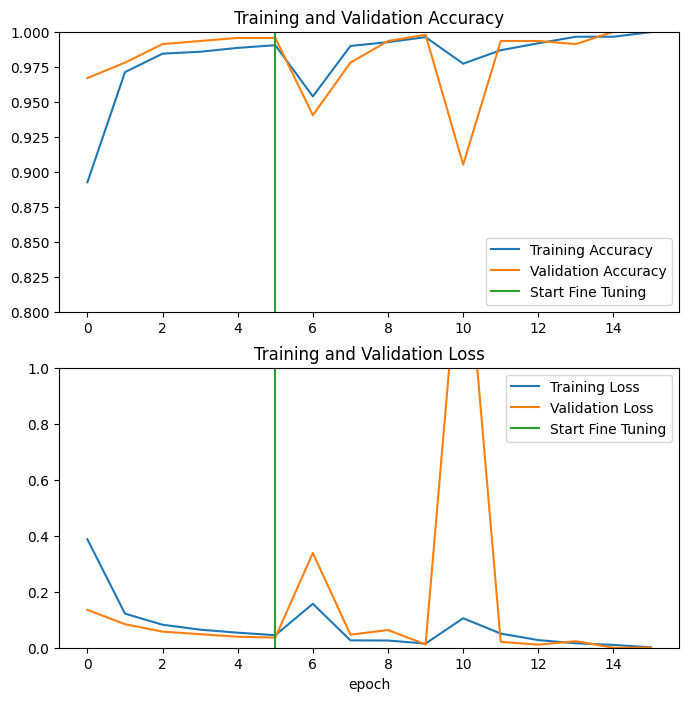

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Step 1: install libs (run once)
!pip install -q scikit-learn seaborn


15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 1.4435e-05
Test accuracy : 1.0


Predictions:
 [1 4 2 1 4 2 2 3 3 0 0 2 3 3 4 4 1 2 2 0 3 1 1 2 2 2 1 0 3 3 4 1]
Labels:
 [1 4 2 1 4 2 2 3 3 0 0 2 3 3 4 4 1 2 2 0 3 1 1 2 2 2 1 0 3 3 4 1]


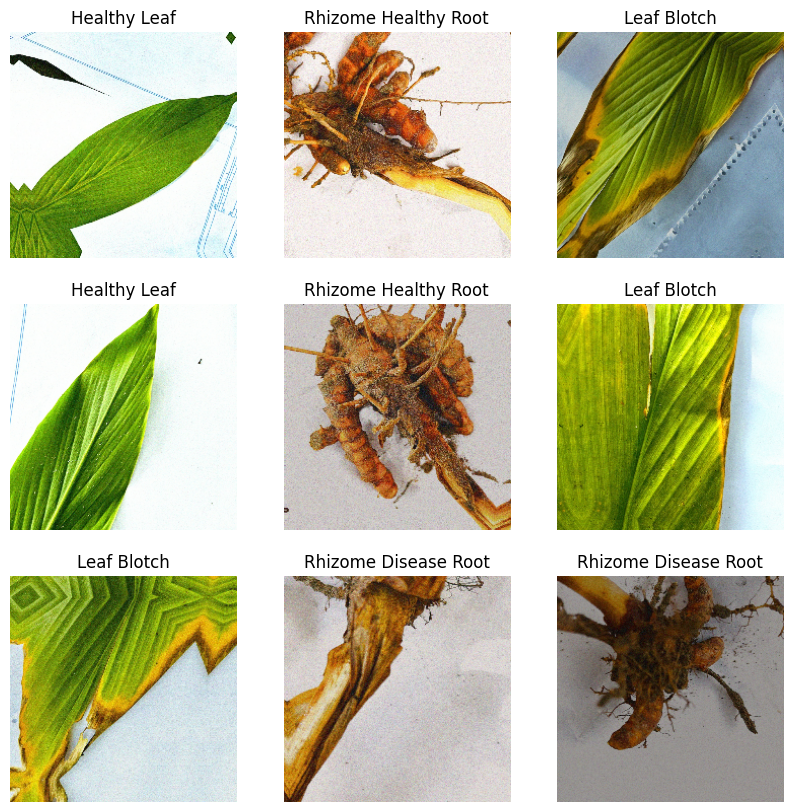

In [36]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions,axis=1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [37]:
model.save("plant_disease_recog_model_pwp.keras")

In [41]:
import numpy as np

# Combine history from initial training and fine-tuning
total_train_acc = history.history['accuracy'] + history_fine.history['accuracy']
total_val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
total_train_loss = history.history['loss'] + history_fine.history['loss']
total_val_loss = history.history['val_loss'] + history_fine.history['val_loss']

print(f"Latest Training Accuracy: {total_train_acc[-1]:.4f}")
print(f"Latest Validation Accuracy: {total_val_acc[-1]:.4f}")
print(f"Testing Accuracy: {accuracy:.4f}")
print(f"Latest Training Loss: {total_train_loss[-1]:.4f}")
print(f"Latest Validation Loss: {total_val_loss[-1]:.4f}")

Latest Training Accuracy: 0.9997
Latest Validation Accuracy: 1.0000
Testing Accuracy: 1.0000
Latest Training Loss: 0.0011
Latest Validation Loss: 0.0000


In [42]:
model.save("plant_disease_recog_model_pwp.keras")